# Investigation of the Equilibrium Paths of the Box Beam Reinforced with Ribs and Stiffeners

In our [last notebook](15_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs.ipynb) we ascertained the existence of complimentary equilibrium paths beyond the natural path for the box beam reinforced with ribs only. In this notebook we are going to perform an analogous investigation for the box beam reinforced with ribs and stiffners.

* [Setup of the numerical model](#numerical-model)
* [Verification of the existence of other equilibrium paths](#verification)
* [Visualization of 3D equilibrium diagram and of deformation shapes](#visualization)
* [Conclusion](#conclusion)

In [1]:
import matplotlib.pyplot as plt  # import matplotlib
import tol_colors as tc  # import package for colorblind-friendly colors

# Set default color cycle to TOL bright
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))
# Enable interactive plots
%matplotlib widget

## Setup of the numerical model <a name="numerical-model"></a>

***

We consider the same box beam reinforced with ribs and stiffeners analyzed in our [twelfth notebook](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb).

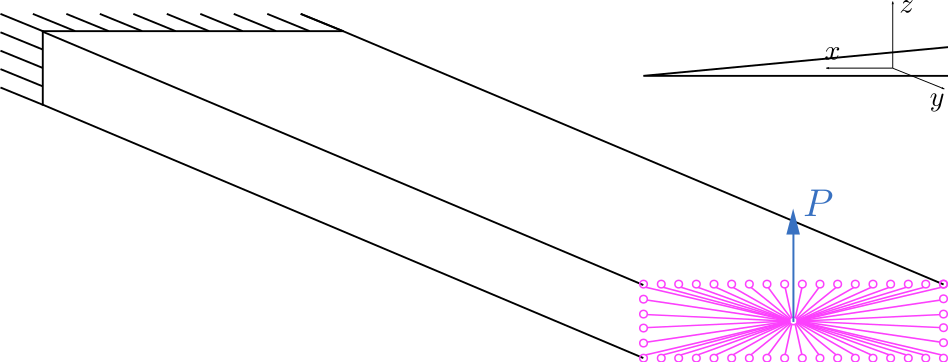

In [2]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join("resources", "08_BoxBeamConcentratedLoad.svg"))

In [3]:
import numpy as np

# Define geometry
AR = 9.   # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
l = AR*w/2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f"""
Box beam dimensions:
- width: {w/1e3:.1f} m
- length: {l/1e3:.1f} m
- height: {h/1e3:.1f} m
- wall thickness: {t:.1f} mm""")

# Define ribs location
ribs_spacing = w/2  # half of box beam's width
no_ribs = int(np.ceil(l/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # calculate y-coordinates of the ribs
np.set_printoptions(precision=0)
print(f"Number of ribs: {no_ribs:.0f}")
print(f"Ribs\' y-coordinate [mm]:")
print(ribs_y_locations)

# Define location and height of stiffeners
stiffeners_spacing = ribs_spacing/1.4
no_stiffeners = int(np.ceil(w/stiffeners_spacing)) - 1
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]
stiffeners_height = h/10
print(f"Number of stiffeners: {no_stiffeners:d}")
print(f"Stiffeners x-coordinate [mm]:")
print(stiffeners_x_locations)
print(f"Stiffeners height: {stiffeners_height:.0f} mm")

# Define material
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio


Box beam dimensions:
- width: 1.0 m
- length: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm
Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]
Number of stiffeners: 2
Stiffeners x-coordinate [mm]:
[333. 667.]
Stiffeners height: 20 mm


Let's define the mesh using a shell element of 47 mm, as found in a previous [mesh convergence study](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb#mesh-convergence). We use the function `mesh_stiffened_box_beam_with_pyvista` from the `box_beam_utils` module and then we call the function `create_base_bdf_input` from the same module, which generates a `BDF` object of our box beam with material properties, nodes, elements, boundary conditions and output files defaults. Finally, we print the cards of the `BDF` object.

In [4]:
from resources import box_beam_utils

shell_element_length = 47.  # [mm]
box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h,
                                                                    stiffeners_x_coordinates=stiffeners_x_locations,
                                                                    stiffeners_height=stiffeners_height,
                                                                    element_length=shell_element_length)
nodes_coordinates_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                    nodes_xyz_array=nodes_coordinates_array,
                                                    nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 8562

bdf.elements: 0
  CQUAD4   : 8784

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now we add a concentrated upward force at the center of the tip section, connecting with a `RBE3` element the nodes on the edge of the section to a new node in the center.

In [5]:
# Add master node of tip section
tip_master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf.add_grid(tip_master_node_id, [w/2, l, 0.])

# Find id of the nodes on the edge of the tip rib
tolerance = shell_element_length/100  # geometric tolerance to find the nodes on the edge of the tip rib
tip_edge_nodes_ids = [nid for nid in box_beam_bdf.nodes if (np.abs(box_beam_bdf.nodes[nid].xyz[1] - l) < tolerance) &  # y = l
                      (np.abs((box_beam_bdf.nodes[nid].xyz[0]) < tolerance) |  # x = 0
                       (np.abs(box_beam_bdf.nodes[nid].xyz[0] - w) < tolerance) |  # x = w
                       (np.abs(box_beam_bdf.nodes[nid].xyz[2] - h/2) < tolerance) |  # z = -h/2
                       (np.abs(box_beam_bdf.nodes[nid].xyz[2] + h/2) < tolerance))]  # z = h/2

# Add RBE3 to connect master node with edge nodes of tip rib
rbe3_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe3(eid=rbe3_eid, refgrid=tip_master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids),
                      comps=['123456']*len(tip_edge_nodes_ids), Gijs=tip_edge_nodes_ids)

# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf.add_force(sid=force_set_id, node=tip_master_node_id, mag=concentrated_force_magnitude,
                       xyz=concentrated_force_direction)

FORCE         11    8563              1.      0.      0.      1.

Finally we set up the arc-length method with default parameters calling the function `set_up_arc_length_method` from the `pynastran_utils` module.

In [6]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

pynastran_utils.set_up_arc_length_method(box_beam_bdf)  # set up SOL 106 with arc-length method using default parameters

## Verification of the existence of other equilibrium paths <a name="verification"></a>

***

In a [previous sensitivity study](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb#nonlinear-analysis-parameters) of the nonlinear analysis parameters we obtained different load-displacement curves for different combination of convergence tolerances. While we previously attributed this discrepancy to the accuracy of the nonlinear solution, now we are going to investigate whether the computed equilibrium points actually belong to different equilibrium paths.

Similarly to our last two notebooks, we are going to unload the box beam from the final equilibrium point of analyses carried out with different convergence tolerances using fine arc-length increments. We start with a first analysis employing the load and energy error functions and loose convergence tolerances and we define the two subcases with the following nonlinear analysis parameters:

1. concentrated tip load, load and energy error functions, $\mathrm{EPSP}=\mathrm{EPSW}=10^{-1}$, default remaining parameters;
2. no load, load and displacement error functions with vector component method, fine arc-length increments:
    - $\Delta\mu^1=0.01$,
    - $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$,
    - $\mathrm{MAXBIS}=10$,
    - $\mathrm{MINALR}=0.01$,
    - $\mathrm{MAXALR}=1.0001$,
    - $\mathrm{DESITER}=5$.
    - $\mathrm{MXINC}=100$.

Let's recall the buckling load predicted by SOL 105 and create the two subcases.

In [7]:
# Create first subcase to load the structure
SOL_105_BUCKLING_LOAD = 8424.  # [N]
load_set_id = force_set_id + 1  # define id of LOAD card
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[2*SOL_105_BUCKLING_LOAD],
                      load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set
box_beam_bdf.nlparms[1].eps_p = 1e-1  # change convergence tolerance for load function
box_beam_bdf.nlparms[1].eps_w = 1e-1  # change convergence tolerance for energy function

# Create second subcase to unload the structure
zero_load_set_id = load_set_id + 1  # id of LOAD card
box_beam_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])  # add LOAD card with zero applied load
second_subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=second_subcase_id,
                                           load_set_id=zero_load_set_id)  # create subcase with zero applied load
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, subcase_id=second_subcase_id,
                                         nlparm_id=second_subcase_id, ninc=100, conv='PUV', eps_p=1e-3,
                                         eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.0001, desiter=5,
                                         maxinc=100)  # set up arc-length method for second subcase using parameters for very fine resolution of equilibrium path

Let's run the analysis by calling the function `run_tangent_stiffness_matrix_eigenvalue_calculation` from the `pynatran_utils` module, using `no_eigenvalues=10` to calculate the 10 lowest eigenvalue of the tangent stiffness matrix at each converged iteration.

In [8]:
from resources import pynastran_utils

# Define analysis directory
analysis_directory_name = "16_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs_and_Stiffeners"
analysis_directory_path = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

# Run analysis
method_set_id = zero_load_set_id + 1  # id of the EIGRL card associated to the METHOD case command
input_name = "equilibrium_path_verification_epsp1e-1"
no_eigenvalues = 10
sol_106_epsp1em1_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id,
    analysis_directory_path=analysis_directory_path, input_name=input_name,
    no_eigenvalues=no_eigenvalues, run_flag=False)

Nastran job equilibrium_path_verification_epsp1e-1.bdf completed
Wall time: 525.0 s


Analogously to our last two notebooks, we want to plot the load-displacement diagram and the eigenvalues of the tangent stiffness matrix. Since in our last notebook we noticed that the 3D equilibrium diagram with local and tip displacements conveyed a better insight in the results of the analyses, this time we want to define a function to visualize the applied load against the local displacement nondimensionalized wtiht the width $w$ and the tip displacement nondimensionalized with the length of the box beam, $l$. Similarly to our last notebooks, we want to evaluate the local displacement as the displacement along the $z$-axis at the node where the linear buckling analysis predicts the largest displacement. For this reason we read the results of the linear buckling analysis obtained in a [previous notebook](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb#mesh-convergence) and we find the node with the largest displacement in the critical buckling mode.

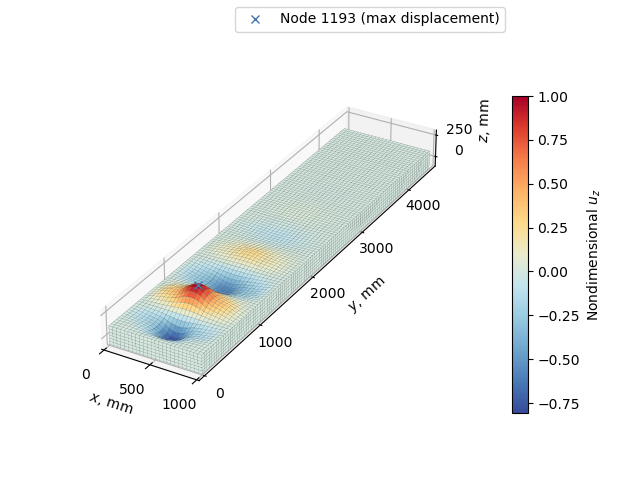

In [9]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 file

# Read op2 file of linear buckling analysis
linear_buckling_directory_path = os.path.join(
    os.getcwd(), "analyses", "12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners")
linear_buckling_input_name = f"linear_buckling_{len(box_beam_bdf.elements)}_elements"
sol_105_op2_filepath = os.path.join(linear_buckling_directory_path, linear_buckling_input_name + '.op2')
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[second_subcase_id].data[
    0, :, 0:3], axis=1))  # find index of max displacement magnitude
MAX_DISPLACEMENT_NODE_ID = sol_105_op2.eigenvectors[second_subcase_id].node_gridtype[
    max_displacement_index, 0]

# Plot critical buckling mode
amplification_factor = 200
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=second_subcase_id,
                                                 displacement_amplification_factor=amplification_factor,
                                                 displacement_component='tz', colormap='sunset')

# Plot node of max displacement
max_displacement_node_xyz = sol_105_op2.nodes[MAX_DISPLACEMENT_NODE_ID].xyz + amplification_factor*sol_105_op2.eigenvectors[
    second_subcase_id].data[0, max_displacement_index, 0:3]  # we multiply the eigenvector by the default displacement scale factor of plot_buckling_mode
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {MAX_DISPLACEMENT_NODE_ID:d} (max displacement)", zorder=4)
ax.legend()

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-0.05, .14))  # move colorbar upwards

# Set axes ticks and labels' position and show plot
adjust_3d_plot(ax, cbar)
plt.show()

Now we define the function `plot_3d_load_displacement_diagram` to plot the 3D equilibrium diagram and the function `plot_tangent_stiffness_matrix_eigenvalues` to plot the eigenvalues of the tangent stiffness matrix against the increment number and the applied load.

In [10]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

Z_COMPONENT_INDEX = 2  # used to select translation along the z-axis for both applied loads and displacements
MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors

# Function to plot the 3D equilibrium diagram
def plot_3d_load_displacement_diagram(local_disp, tip_disp, loads):
    plt.figure()  # create figure
    ax_3d = plt.axes(projection='3d')  # create 3D axes
    for subcase in loads:  # iterate through the subcases
        ax_3d.plot(local_disp[subcase][:, Z_COMPONENT_INDEX]/w,
                   tip_disp[subcase][:, Z_COMPONENT_INDEX]/l,
                   loads[subcase][:, Z_COMPONENT_INDEX]/SOL_105_BUCKLING_LOAD,
                   marker=MARKERS[subcase - 1], label=f"Subcase {subcase:d}")
    ax_3d.set_xlabel(f"$u_{{z,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/w$")
    ax_3d.set_ylabel("$u_{z,\,tip}/l$")
    ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
    ax_3d.grid(visible=True)
    ax_3d.legend()
    plt.show()

# Function to plot the eigenvalues of the tangent stiffness matrix
def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues from f06 file
    f06_path = os.path.join(directory_path, input_name + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    iterations_count = 1
    # Divide lowest eigenvalues by subcase and plot them
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase in loads:
        no_load_steps = len(loads[subcase])
        eigenvalues_by_subcase[subcase] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number in first subplot
        eigvals_axs[0].plot(np.arange(iterations_count,
                                      eigenvalues_by_subcase[subcase].shape[1] + iterations_count),
                                      eigenvalues_by_subcase[subcase].T, MARKERS[subcase - 1],
                                      color=COLORS[subcase - 1], label=f"Subcase {subcase:d}")
        iterations_count += eigenvalues_by_subcase[subcase].shape[1]
        # Plot eigenvalues vs applied load in second subplot
        eigvals_axs[1].plot(loads[subcase][:eigenvalues_by_subcase[subcase].shape[1], Z_COMPONENT_INDEX
                                           ]/SOL_105_BUCKLING_LOAD, eigenvalues_by_subcase[subcase].T,
                                           MARKERS[subcase - 1], color=COLORS[subcase - 1])
    # Set plot appearance
    eigvals_axs[0].set_xlabel("increment number")
    eigvals_axs[0].set_ylabel("$\lambda$, N/mm")
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel("$P/P_\mathrm{SOL\/105}$")
    eigvals_axs[1].grid(visible=True)
    plt.show()

Let's read the load and displacement history from the `OP2` object returned by the function `run_tangent_stiffness_matrix_eigenvalue_calculation` and plot the 3D equilibrium diagram and the eigenvalue diagram.

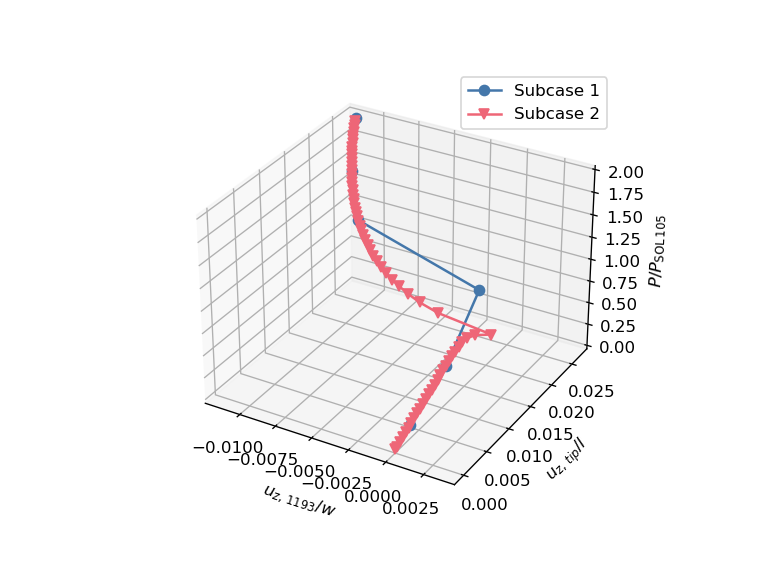

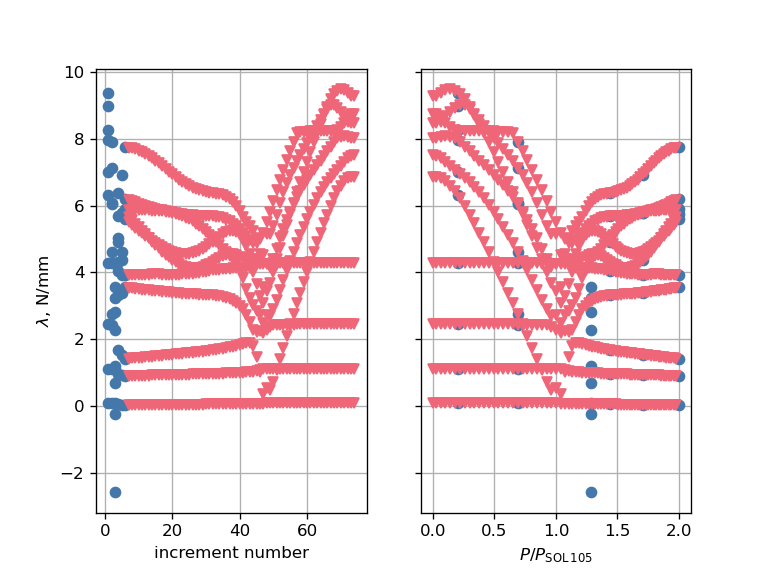

In [11]:
# Set default dpi of figures
plt.rcParams['figure.dpi'] = 120

# Read load and displacement history from the op2 file
_, applied_loads_epsp1em1, tip_displacements_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_epsp1em1_op2, displacement_node_id=tip_master_node_id)
_, _, local_displacements_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_epsp1em1_op2, displacement_node_id=MAX_DISPLACEMENT_NODE_ID)

# Plot results
plot_3d_load_displacement_diagram(local_displacements_epsp1em1, tip_displacements_epsp1em1, applied_loads_epsp1em1)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_epsp1em1)

We can see that during the first subcase, the solver jumps to an unstable equilibrium point at an applied load of approximately $P/P_\text{SOL 105}=1.28$ and then it jumps back on stable equilibrium points. In the second subcase, the solver appears to follow a completely stable equilibrium path, bu the equilibrium diagram reveals that actually there might be a jump from the stable segment of a complementary path to the natural path.

In fact, similarly to our last notebook, by looking at the trend of the local displacement from the ground state towards increasing applied loads, we can notice that it first assumes increasing positive values as the solver approaches and exceeds $P/P_\text{SOL 105}=1$ and then it jumps to a negative value. Inspecting the f06 file, we find out that the solver generally converged in 2 or 3 iterations for each arc-length increment, but it converged in 5 iterations for the increment immediately before the jump and in 7 iterations for the incremenet corresponding to the jump.

Analogously to our last notebook, this results suggest that the predictor step of the arc-length solver landed closer to a different equilibrium path, and that the corrector step needs more iterations to converge to the equilibrium point. For this reason we repeat the analysis setting the maximum number of iterations in the second subcase to 4, so that the solver can bisect the increment when it cannot easily converge to the equilibrium point. We also increase the number of allowed increments to 200 becasue we expect the increments to become smaller when the solver approaches the jump.

Nastran job equilibrium_path_verification_epsp1e-1_maxiter4.bdf completed
Wall time: 1205.0 s


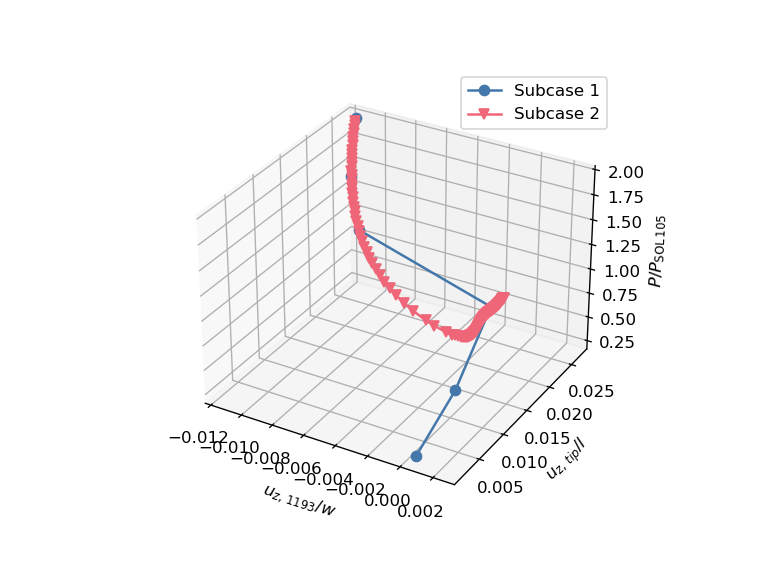

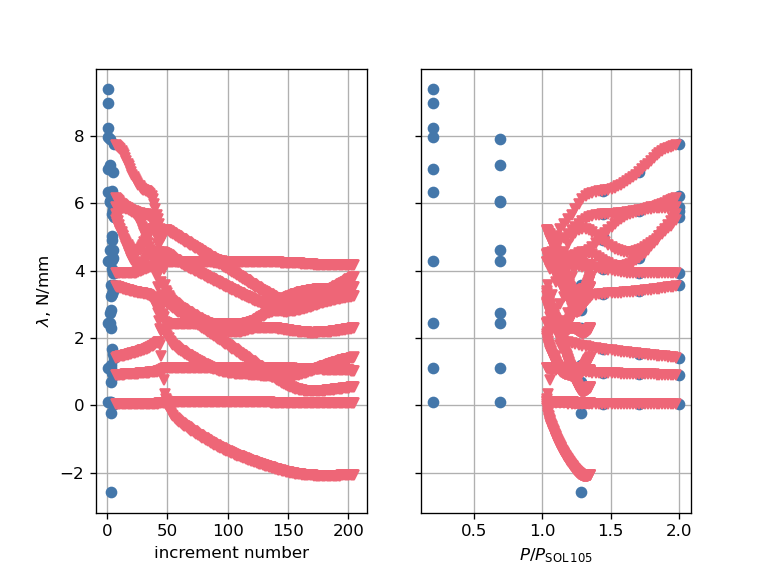

In [12]:
# Set maximum number of iterations for each increment of second subcase to 4
box_beam_bdf.nlparms[second_subcase_id].max_iter = 4
box_beam_bdf.nlpcis[second_subcase_id].mxinc = 200

# Run analysis
input_name = "equilibrium_path_verification_epsp1e-1_maxiter4"
sol_106_epsp1em1_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id,
    analysis_directory_path=analysis_directory_path, input_name=input_name,
    no_eigenvalues=no_eigenvalues, run_flag=False)

# Read load and displacements and plot results
_, applied_loads_epsp1em1, tip_displacements_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_epsp1em1_op2, displacement_node_id=tip_master_node_id)
_, _, local_displacements_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_epsp1em1_op2, displacement_node_id=MAX_DISPLACEMENT_NODE_ID)
plot_3d_load_displacement_diagram(local_displacements_epsp1em1, tip_displacements_epsp1em1, applied_loads_epsp1em1)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_epsp1em1)

Now we can indeed observe that equilibrium path that the box beam follows when it is unloaded from the final equilibrium point of the first subcase is a complementary path. The solver follows the stable part of this path from the final equilibrium point of the first subcase to a minimum applied load of approximately $P/P_\text{SOL 105}=1.04$ and then it keeps following the unstable part of the path.

Now let's investigate what equilibrium path we find when we load the box beam in the first subcase with tighter convergence tolerances. We define the following subcases, run the analysis and plot the results:

1. concentrated tip load, load and energy error functions, $\mathrm{EPSP}=10^{-3},\,\mathrm{EPSW}=10^{-7}$, default remaining parameters;
2. no load, load and displacement error functions with vector component method, fine arc-length increments:
    - $\Delta\mu^1=0.01$,
    - $\mathrm{MAXITER}=4$,
    - $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$,
    - $\mathrm{MAXBIS}=10$,
    - $\mathrm{MINALR}=0.01$,
    - $\mathrm{MAXALR}=1.0001$,
    - $\mathrm{DESITER}=5$.
    - $\mathrm{MXINC}=200$.

In the second subcase we keep $\mathrm{MAXITER}=4$ and $\mathrm{MXINC}=200$ to avoid potential jumps of the solver.

Nastran job equilibrium_path_verification_epsp1e-3.bdf completed
Wall time: 548.0 s


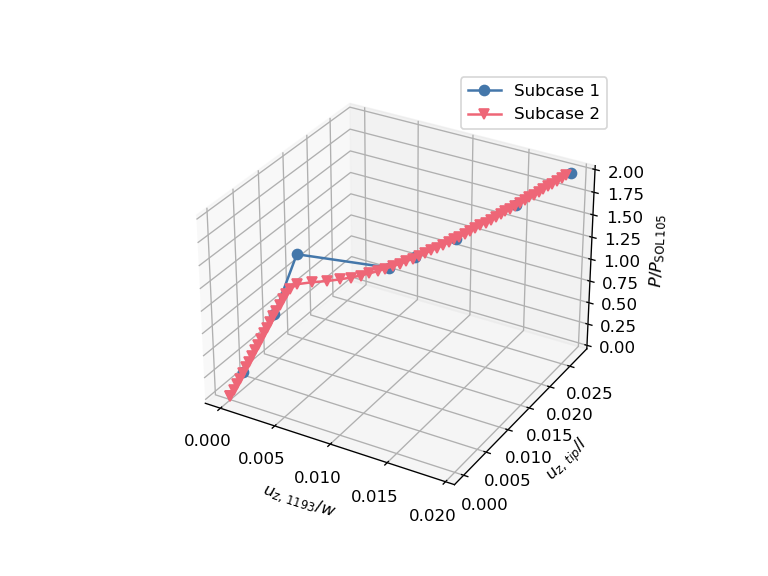

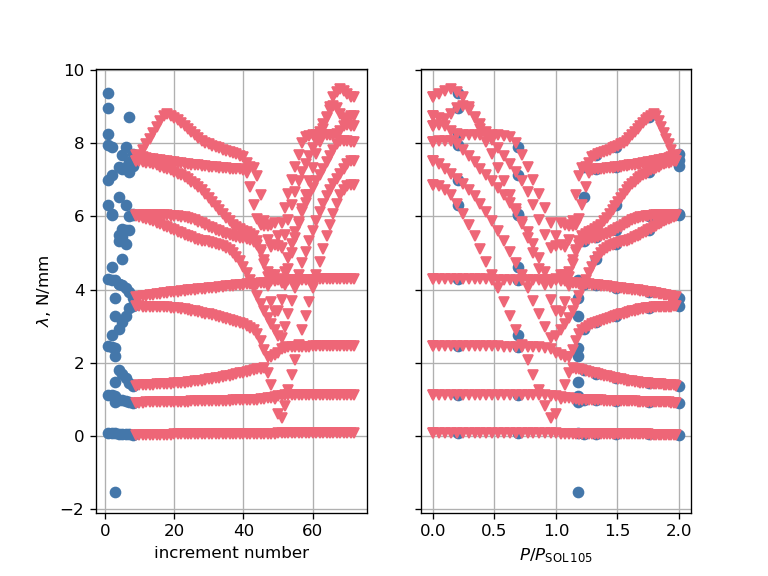

In [13]:
# Set convergence tolerances for first subcase
first_subcase_id = 1
box_beam_bdf.nlparms[first_subcase_id].eps_p = 1e-3
box_beam_bdf.nlparms[first_subcase_id].eps_w = 1e-7

# Run analysis
input_name = "equilibrium_path_verification_epsp1e-3"
sol_106_epsp1em3_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id,
    analysis_directory_path=analysis_directory_path, input_name=input_name,
    no_eigenvalues=no_eigenvalues, run_flag=False)

# Read load and displacements and plot results
_, applied_loads_epsp1em3, tip_displacements_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_epsp1em3_op2, displacement_node_id=tip_master_node_id)
_, _, local_displacements_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_epsp1em3_op2, displacement_node_id=MAX_DISPLACEMENT_NODE_ID)
plot_3d_load_displacement_diagram(local_displacements_epsp1em3, tip_displacements_epsp1em3, applied_loads_epsp1em3)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_epsp1em3)

Aslo here, in the first subcase the solver jumps to an unstable equilibrium point and back to stable equilibrium points. However, in this case the second subcase reveals that the final equilibrium point of the first subcase belongs to the natural equilibrium path, which is followed by the solver when the box beam is unloaded.

## Visualization of 3D equilibrium diagram and deformation shapes <a name="visualization"></a>

***

Now we want to visualize together the natural and the complementary path on the 3D equilibrium diagram.

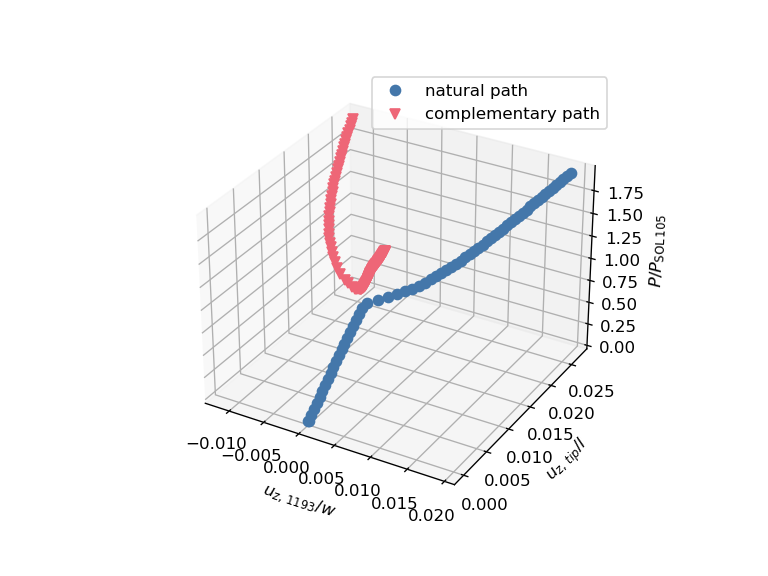

In [14]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot applied load against tip and local displacements
nondimensional_local_displacements = {
    "natural path": local_displacements_epsp1em3[second_subcase_id][:, Z_COMPONENT_INDEX]/w,
    "complementary path": local_displacements_epsp1em1[second_subcase_id][:, Z_COMPONENT_INDEX]/w}
nondimensional_tip_displacements = {
    "natural path": tip_displacements_epsp1em3[second_subcase_id][:, Z_COMPONENT_INDEX]/l,
    "complementary path": tip_displacements_epsp1em1[second_subcase_id][:, Z_COMPONENT_INDEX]/l}
nondimensional_applied_loads = {
    "natural path": applied_loads_epsp1em3[second_subcase_id][:, Z_COMPONENT_INDEX]/SOL_105_BUCKLING_LOAD,
    "complementary path": applied_loads_epsp1em1[second_subcase_id][:, Z_COMPONENT_INDEX]/SOL_105_BUCKLING_LOAD}
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 nondimensional_applied_loads[key], MARKERS[count], color=COLORS[count], label=key)  # plot applied loads against tip and local displacements

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/w$")
ax_3d.set_ylabel("$u_{z,\,tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

What is the deformation shape on the different equilibrium paths? Let's explore this by cutting the equilibrium paths with a plane at $P/P_\text{SOL 105}=1.35$.

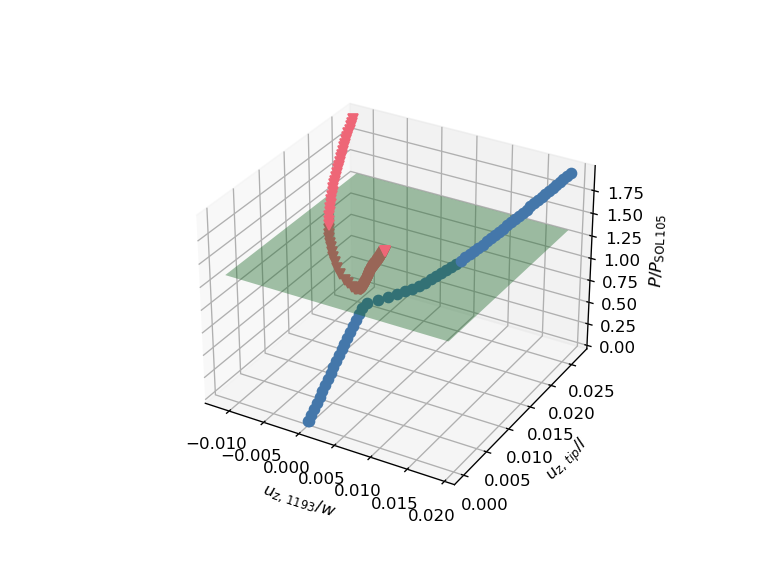

Deformation on natural path:


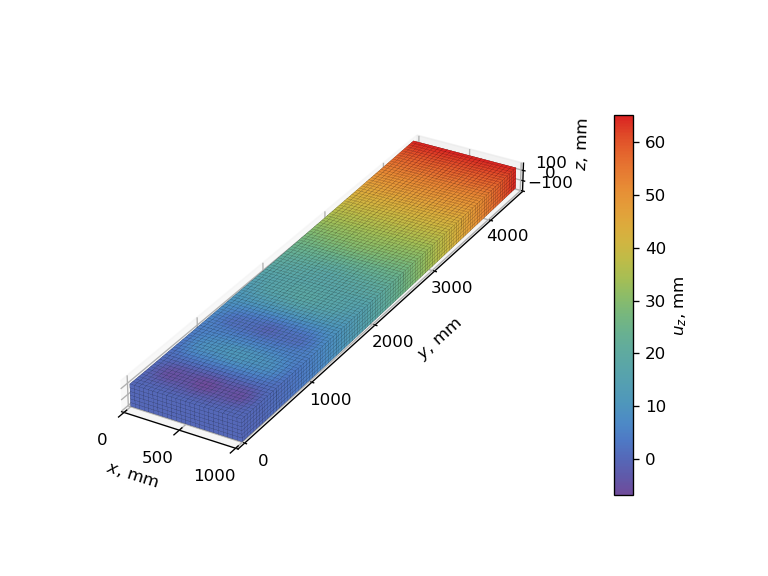

Deformations on complementary path:


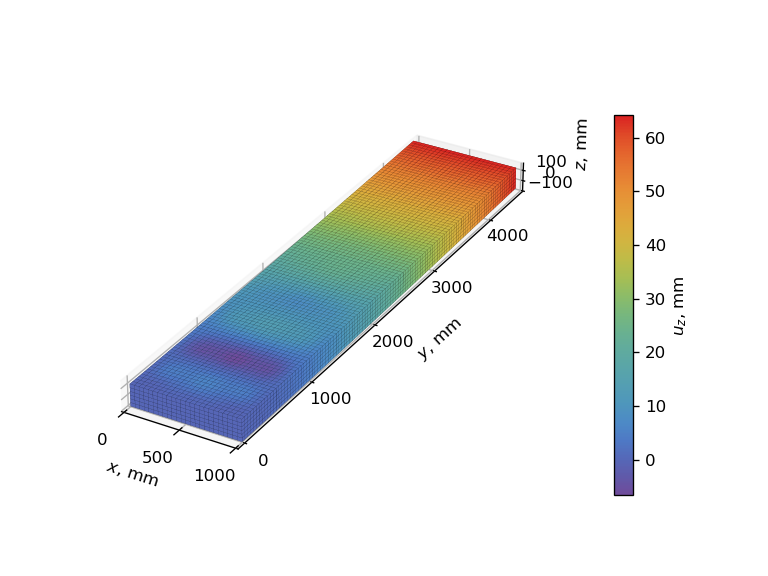

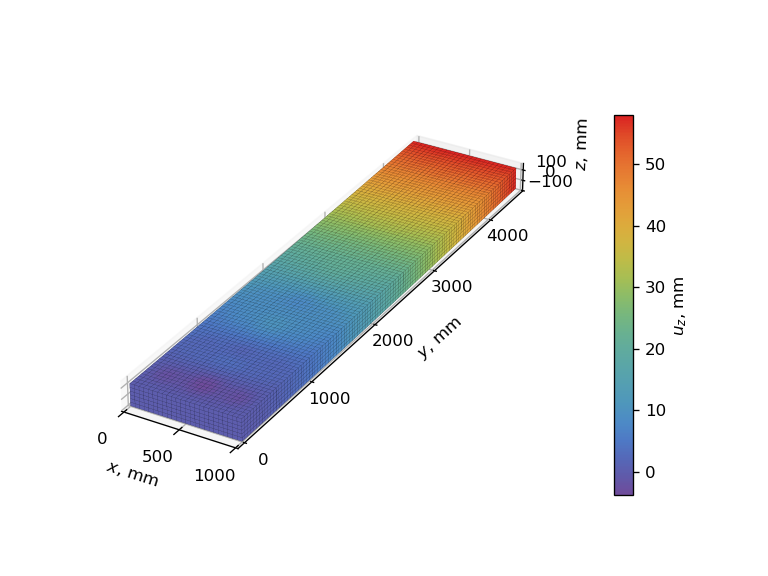

In [15]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot part of the equilibrium paths that should not be visible on top of the plane
load_factor = 1.35
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key] < load_factor, nondimensional_applied_loads[key], np.nan),
                 MARKERS[count], color=COLORS[count])

# Plot P/Psol105=1.35 plane
local_displacements_array = np.concatenate(tuple(nondimensional_local_displacements[key] for key in
                                                 nondimensional_local_displacements))
tip_displacements_array = np.concatenate(tuple(nondimensional_tip_displacements[key] for key in
                                               nondimensional_tip_displacements))
xx, yy = np.meshgrid([np.min(local_displacements_array), np.max(local_displacements_array)],
                     [np.min(tip_displacements_array), np.max(tip_displacements_array)])
ax_3d.plot_surface(xx, yy, np.full_like(xx, load_factor), alpha=0.4, color=COLORS[len(nondimensional_local_displacements)])

# Plot part of the equilibrium paths that should be visible on top of the plane
for count, key in enumerate(nondimensional_local_displacements.keys()):
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key] >= load_factor, nondimensional_applied_loads[key], np.nan),
                 MARKERS[count], color=COLORS[count], zorder=3)

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/w$")
ax_3d.set_ylabel("$u_{z,\,tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
plt.show()

# Plot static deformation of natural path
print("Deformation on natural path:")
load_step = np.argmin(np.abs(nondimensional_applied_loads["natural path"] - load_factor)) + 1  # find closest load step to plane
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_epsp1em3_op2, subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

# Plot first deformation on complementary path 1
print("Deformations on complementary path:")
key = "complementary path"
min_load_index = np.argmin(nondimensional_applied_loads[key])
load_step = np.argmin(np.abs(nondimensional_applied_loads[key][:min_load_index] - load_factor)) + 1  # find closest load step to plane on first side of the path
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_epsp1em1_op2, subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

# Plot second deformation on complementary path 1
load_step = np.argmin(np.abs(nondimensional_applied_loads[key][min_load_index:] - load_factor)) + min_load_index + 1  # find closest load step to plane on second side of the path
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_epsp1em1_op2, subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

From the plots above it is clear that the deformation is different for every equilibrium point inspected. The top skin appears in a buckled-like state for the point on the natural path and for the first point on the complementary path. In addition, we can observe that the two deformations are one the "mirror" image of the other, as where the natural path exhibits a positive out-of-plane displacement, the complementary path exhibits a negative out-of-plane displacement and viceversa.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have verified the existence of a complementary equilibrium path for the box beam reinforced with ribs and stiffeners. More specifically, we were able to find a complementary path that was partly unstable and partly stable. Similarly to our last notebooks, this was possible by choosing very coarse arc-length and by playing around with the convergence tolerances of the nonlinear analysis. The same caveats and reflections apply here as well.